In [2]:
import torch.nn as nn
import math
from omni import ODConv2d, ODConvBN
from mixup import mixup_data, mixup_criterion

__all__ = ['mobilenetv3_large', 'mobilenetv3_small']

In [3]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6

class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


In [4]:
def conv_3x3(inp, oup, stride, batch_norm = True):
    layers = [
        nn.Conv2d(inp, oup, kernel_size=3, stride=1,
                  padding=1, bias=False),
        h_swish()
    ]
    if batch_norm:
        layers.insert(1, nn.BatchNorm2d(oup))

    return nn.Sequential(*layers)

def conv_1x1(inp, oup, batch_norm = True):
    layers = [
        nn.Conv2d(inp, oup, kernel_size=1, stride=1,
                  padding=0, bias=False),
        h_swish()
    ]
    if batch_norm:
        layers.insert(1, nn.BatchNorm2d(oup))

    return nn.Sequential(*layers)

In [5]:
def od_conv_1x1(inp, oup, stride = 1, kernel_num = 4,
                temperature = 60,
                batch_norm = True):
    return nn.Sequential(
        ODConvBN(inp, oup, kernel_size = 1, stride = stride,
            kernel_num = kernel_num, temperature = temperature) \
                if batch_norm == True else \
        ODConv2d(inp, oup, kernel_size = 1, stride = stride,
            kernel_num = kernel_num, temperature = temperature),

        h_swish()
    )

def od_conv_3x3(inp, oup, stride = 1,
                kernel_num = 4, temperature = 60,
                batch_norm = True):
    return nn.Sequential(
         ODConvBN(inp, oup, kernel_size = 3, stride = stride,
            kernel_num = kernel_num, temperature = temperature) \
                if batch_norm == True else \
        ODConv2d(inp, oup, kernel_size = 3, stride = stride,
            kernel_num = kernel_num, temperature = temperature),

        h_swish()
    )

In [6]:
class InvertedResidualOD(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size,
                 stride, use_se, use_hs,
                 kernel_num = 4, temperature = 60.0):
        super(InvertedResidualOD, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup
        print("Using OmniDimensional")
        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                ODConvBN(hidden_dim, hidden_dim, kernel_size, stride,
                         groups=hidden_dim, kernel_num = kernel_num,
                         temperature = temperature),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                ODConv2d(hidden_dim, oup, 1, 1, kernel_num = kernel_num,
                         temperature = temperature),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                ODConvBN(inp, hidden_dim, kernel_size = 1, stride = 1,
                         kernel_num = kernel_num, temperature = temperature),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                ODConvBN(hidden_dim, hidden_dim, kernel_size,
                         stride, groups=hidden_dim, kernel_num = kernel_num,
                         temperature = temperature),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # pw-linear
                ODConv2d(hidden_dim, oup, 1, 1, kernel_num = kernel_num,
                         temperature = temperature),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


In [7]:
class InvertedResidual(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se, use_hs):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup

        print("Using Normal")
        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


## MobileNetV3

In [8]:
class MobileNetV3(nn.Module):
    def __init__(self, cfgs, mode, hyper_opt, kernel_num,
                 temperature, num_classes = 10, width_mult=1.,
                 use_od = False, drop_rate = 0.2):
        super(MobileNetV3, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = cfgs
        self.use_od = use_od
        assert mode in ['large', 'small']

        num_od = int(hyper_opt)
        self.num_od = num_od
        # building first layer
        input_channel = _make_divisible(16 * width_mult, 8)

        layers = []
        if num_od > 0:
            print("Using OD")
            layers.append(od_conv_3x3(3, input_channel, stride = 2,
                                      kernel_num = kernel_num,
                                      temperature = temperature))
        else:
            print("Using Normal")
            layers.append(conv_3x3(3, input_channel, stride = 2))

        # building inverted residual blocks
        block = InvertedResidual if use_od == False else InvertedResidualOD
        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            if use_od == True:
                layers.append(block(input_channel, exp_size, output_channel,
                                k, s, use_se, use_hs, kernel_num = kernel_num,
                                temperature = temperature))
            else:
                layers.append(block(input_channel, exp_size, output_channel,
                                    k, s, use_se, use_hs))
            input_channel = output_channel
        self.features = nn.Sequential(*layers)

        # building last several layers
        if num_od >= 2:
            print("Using OD")
            self.conv = od_conv_1x1(input_channel, exp_size,
                                    kernel_num = kernel_num,
                                    temperature = temperature)
        else:
            print("Using Normal")
            self.conv = conv_1x1(input_channel, exp_size)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_channel = {'large': 1280, 'small': 1024}

        output_channel = _make_divisible(output_channel[mode] * width_mult, 8) if width_mult > 1.0 else output_channel[mode]

        omni_layers = []
        not_omni_layers = []
        temp_od = num_od - 2

        self.list_layers = []
        for i in range(2):
            if temp_od > 0:
                print("Using OD")
                self.list_layers.append("OD")
            else:
                print("Using Normal")
                self.list_layers.append("Normal")

            temp_od -= 1


        input_channel = exp_size
        for layer in self.list_layers:
            if layer == "OD":
                omni_layers.append(od_conv_1x1(input_channel, output_channel,
                                          kernel_num = kernel_num,
                                          temperature = temperature))
            else:
                not_omni_layers.append(nn.Linear(input_channel, output_channel))

            input_channel = output_channel
            output_channel = num_classes

        self.omni_layers = nn.Sequential(*omni_layers)
        self.normal_layers = nn.Sequential(*not_omni_layers)
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = self.omni_layers(x)
        x = x.view(x.size(0), -1)
        x = self.normal_layers(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    def net_update_temperature(self, temperature):
        for modules in self.modules():
            if hasattr(modules, "update_temperature"):
                modules.update_temperature(temperature)

    def display_temperature(self):
        for modules in self.modules():
            if hasattr(modules, "get_temperature"):
                return modules.get_temperature()



In [9]:
def mobilenetv3_large(**kwargs):
    """
    Constructs a MobileNetV3-Large model
    """
    cfgs = [
        # k, t,   c,  SE, HS, s
        [3,   1,  16, 0, 0, 1],
        [3,   4,  24, 0, 0, 2],
        [3,   3,  24, 0, 0, 1],
        [5,   3,  40, 1, 0, 2],
        [5,   3,  40, 1, 0, 1],
        [5,   3,  40, 1, 0, 1],
        [3,   6,  80, 0, 1, 2],
        [3, 2.5,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [5,   6, 160, 1, 1, 2],
        [5,   6, 160, 1, 1, 1],
        [5,   6, 160, 1, 1, 1]
    ]
    return MobileNetV3(cfgs, mode='large', **kwargs)


def mobilenetv3_small(**kwargs):
    """
    Constructs a MobileNetV3-Small model
    """
    cfgs = [
        # k,   t,  c, SE, HS, s
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  40, 1, 1, 2],
        [5,    6,  40, 1, 1, 1],
        [5,    6,  40, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    6,  96, 1, 1, 2],
        [5,    6,  96, 1, 1, 1],
        [5,    6,  96, 1, 1, 1],
    ]

    return MobileNetV3(cfgs, mode='small', **kwargs)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Training

In [11]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

In [12]:
def load_data(data_dir, download = True):

  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  train_data = datasets.CIFAR10(
      root = data_dir, train = True,
      download = download, transform = transform
  )

  test_data = datasets.CIFAR10(
      root = data_dir, train = False,
      download = download, transform = transform
  )

  return (train_data, test_data)

train_data, test_data = load_data('./data/cifar10')

Files already downloaded and verified
Files already downloaded and verified


In [13]:
batch_size = 128
num_workers = 4

train_loader = DataLoader(train_data, batch_size = batch_size,
                          shuffle = True, num_workers = num_workers)
test_loader = DataLoader(test_data, batch_size = batch_size,
                         shuffle = True, num_workers = num_workers)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
import logging
import os
from tqdm.notebook import tqdm

def check_logging_directory(path):
  parent_directory = os.path.dirname(path)
  if not os.path.exists(parent_directory):
    os.makedirs(parent_directory)
    print("Create new directory")

logging_path = './logging/mobilenetv3_small.log'
check_logging_directory(logging_path)

logging.basicConfig(filename=logging_path, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [16]:
import torch.optim

num_epochs = 100
learning_rate = .05

mb_v3 = mobilenetv3_small(num_classes = 10, hyper_opt = 0,
                          kernel_num = 4, temperature = 30,
                           use_od = False, drop_rate = 0.2).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(mb_v3.parameters(), lr=learning_rate, 
                            weight_decay=0.00004, momentum = 0.9)

print(f"The number of parameters: {count_parameters(mb_v3)}")



Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
Using Normal
The number of parameters: 1528106


In [17]:
def adjust_learning_rate(optimizer, epoch, total_epochs, iteration, iter_per_epoch, initial_lr = 0.05):
    current_iter = iteration + epoch * iter_per_epoch
    max_iter = total_epochs * iter_per_epoch

    lr = initial_lr * (1 + np.cos(np.pi * current_iter / max_iter)) / 2

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [18]:
# Huấn luyện mô hình
train_loss, val_loss = [], []
train_acc, val_acc = [], []

epoch_bar = tqdm(desc = 'Epoch',
                 total = num_epochs, position = 1)
train_bar = tqdm(desc = 'Training', total = len(train_loader),
                 position = 1, leave = True)
val_bar = tqdm(desc = 'Validation', total = len(test_loader),
               position = 1, leave = True)

print("🚀 Training MobileNetV3 Small")
logging.info("Training MobileNetV3 Small ")

for epoch in range(num_epochs):

    epoch_bar.set_description(f'Epoch {epoch + 1}/{num_epochs}')

    mb_v3.train()
    running_loss = 0.0
    running_acc = 0.0
    total_loss = 0.0
    total_acc = 0.0

    total = 0
    for i, (X, y) in enumerate(train_loader):

        # if epoch < 25:
        #     temp = get_temperature(i + 1, epoch, len(train_loader), temp_epoch = 25, temp_init = 30.0)
        #     mb_v3.net_update_temperature(temp)
        #     # print(f"The temperature is: {temp}")

        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)

        X, y_origin, y_sampled, lam = mixup_data(X, y, device, alpha = 0.4)
 
        # Forward pass
        output = mb_v3(X)
        loss = criterion(output, y)
        loss = mixup_criterion(criterion, output, y_origin, y_sampled, lam)
        
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (i + 1)
        total_loss += loss_t

        # Backward pass
        loss.backward()
        optimizer.step()

        temp_lr = adjust_learning_rate(optimizer, epoch, num_epochs,
                                       i + 1, len(train_loader), initial_lr = learning_rate)
        
        # Calculating the accuracy
        _, predicted = torch.max(output.data, 1)
        n_correct = (lam * predicted.eq(y_origin.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(y_sampled.data).cpu().sum().float())

        acc_t = n_correct / len(predicted) * 100
        running_acc += (acc_t - running_acc) / (i + 1)

        total_acc += n_correct
        total += y.shape[0]


        train_bar.set_postfix(loss = running_loss,
                              acc = f"{running_acc:.2f}%",
                              epoch = epoch + 1)
        train_bar.update()

    current_loss = total_loss / len(train_loader)
    current_acc = total_acc / total * 100
    train_loss.append(current_loss)
    train_acc.append(current_acc)

    print("========================================")
    print("\033[1;34m" + f"Epoch {epoch + 1}/{num_epochs}" + "\033[0m")
    print(f"Train Loss: {current_loss:.2f}\t|\tTrain Acc: {current_acc:.2f}%")

    logging.info("========================================")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}")
    logging.info(f"Train Loss: {current_loss:.2f}\nTrain Acc: {current_acc:.2f}%")


    # Eval trên valid set
    running_loss = 0.0
    running_acc = 0.0
    total_loss = 0.0
    total_acc = 0.0

    total = 0
    mb_v3.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(test_loader):

            X, y = X.to(device), y.to(device)
            # Forward pass
            output = mb_v3(X)

            # Calculate Loss
            loss = criterion(output, y)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (i + 1)
            total_loss += loss_t

            # Calculate Accuracies
            _, predicted = torch.max(output.data, 1)
            n_correct = (predicted == y).sum().item()
            acc_t = n_correct / len(predicted) * 100
            running_acc += (acc_t - running_acc) / (i + 1)
            total_acc += n_correct

            total += y.shape[0]

            val_bar.set_postfix(loss = running_loss,
                                acc = f"{running_acc:.2f}%",
                                epoch = epoch + 1)
            val_bar.update()

    current_loss = total_loss / len(test_loader)
    current_acc = total_acc / total * 100

    val_loss.append(current_loss)
    val_acc.append(current_acc)

    print(f"Val Loss: {current_loss:.2f}\t|\tVal Acc: {current_acc:.2f}%")
    logging.info(f"Val Loss: {current_loss:.2f}\nVal Acc: {current_acc:.2f}%")

    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()

    print(f"The current learning rate is: {temp_lr}")


print("========================================")
print("Training Completed! 😀")
logging.info("========================================")
logging.info("Training Completed! 😀")

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

🚀 Training MobileNetV3 Small
Epoch 1/100
Train Loss: 1.78	|	Train Acc: 36.07%
Val Loss: 1.38	|	Val Acc: 51.44%
The current learning rate is: 0.04998766400914329
Epoch 2/100
Train Loss: 1.43	|	Train Acc: 53.27%
Val Loss: 1.03	|	Val Acc: 64.73%
The current learning rate is: 0.04995066821070679
Epoch 3/100
Train Loss: 1.27	|	Train Acc: 59.73%
Val Loss: 0.95	|	Val Acc: 66.43%
The current learning rate is: 0.049889049115077
Epoch 4/100
Train Loss: 1.18	|	Train Acc: 64.32%
Val Loss: 0.80	|	Val Acc: 75.21%
The current learning rate is: 0.04980286753286195
Epoch 5/100
Train Loss: 1.07	|	Train Acc: 68.56%
Val Loss: 0.65	|	Val Acc: 78.96%
The current learning rate is: 0.04969220851487845
Epoch 6/100
Train Loss: 1.10	|	Train Acc: 67.97%
Val Loss: 0.69	|	Val Acc: 78.28%
The current learning rate is: 0.049557181268217225
Epoch 7/100
Train Loss: 1.02	|	Train Acc: 70.32%
Val Loss: 0.60	|	Val Acc: 82.12%
The current learning rate is: 0.049397919048468686
Epoch 8/100
Train Loss: 1.02	|	Train Acc: 70.67

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 34/100
Train Loss: 0.68	|	Train Acc: 82.13%
Val Loss: 0.37	|	Val Acc: 89.59%
The current learning rate is: 0.037043841852542884
Epoch 35/100
Train Loss: 0.71	|	Train Acc: 81.05%
Val Loss: 0.39	|	Val Acc: 89.40%
The current learning rate is: 0.03634976249348867
Epoch 36/100
Train Loss: 0.72	|	Train Acc: 80.66%
Val Loss: 0.40	|	Val Acc: 88.82%
The current learning rate is: 0.03564448228912682
Epoch 37/100
Train Loss: 0.65	|	Train Acc: 83.38%
Val Loss: 0.39	|	Val Acc: 89.74%
The current learning rate is: 0.03492869726586952
Epoch 38/100
Train Loss: 0.69	|	Train Acc: 81.39%
Val Loss: 0.38	|	Val Acc: 89.22%
The current learning rate is: 0.03420311381711695
Epoch 39/100
Train Loss: 0.68	|	Train Acc: 82.42%
Val Loss: 0.38	|	Val Acc: 90.10%
The current learning rate is: 0.033468448006132294
Epoch 40/100
Train Loss: 0.68	|	Train Acc: 82.34%
Val Loss: 0.38	|	Val Acc: 90.13%
The current learning rate is: 0.032725424859373686
Epoch 41/100
Train Loss: 0.68	|	Train Acc: 82.02%
Val Loss: 0.40	|

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 90/100
Train Loss: 0.59	|	Train Acc: 83.94%
Val Loss: 0.38	|	Val Acc: 91.49%
The current learning rate is: 0.0012235870926211618
Epoch 91/100
Train Loss: 0.62	|	Train Acc: 82.84%
Val Loss: 0.36	|	Val Acc: 91.57%
The current learning rate is: 0.0009926578580764262
Epoch 92/100
Train Loss: 0.63	|	Train Acc: 82.51%
Val Loss: 0.34	|	Val Acc: 91.61%
The current learning rate is: 0.0007854209717842232
Epoch 93/100
Train Loss: 0.60	|	Train Acc: 83.64%
Val Loss: 0.31	|	Val Acc: 91.78%
The current learning rate is: 0.0006020809515313142
Epoch 94/100
Train Loss: 0.62	|	Train Acc: 82.99%
Val Loss: 0.32	|	Val Acc: 91.67%
The current learning rate is: 0.00044281873178278475
Epoch 95/100
Train Loss: 0.64	|	Train Acc: 81.87%
Val Loss: 0.36	|	Val Acc: 91.64%
The current learning rate is: 0.00030779148512155856
Epoch 96/100
Train Loss: 0.64	|	Train Acc: 82.15%
Val Loss: 0.36	|	Val Acc: 91.67%
The current learning rate is: 0.0001971324671380531
Epoch 97/100
Train Loss: 0.61	|	Train Acc: 83.48%
Val

In [26]:
print(f"The greatest accuracy of this model at epoch: {np.argmax(val_acc) + 1}")
print(f"Accuracy: {np.max(val_acc)}%")

The greatest accuracy of this model at epoch: 97
Accuracy: 91.8%


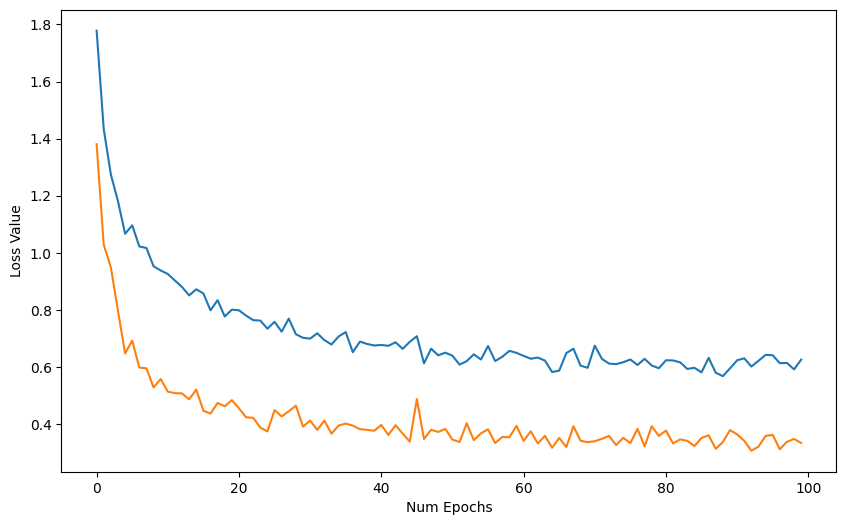

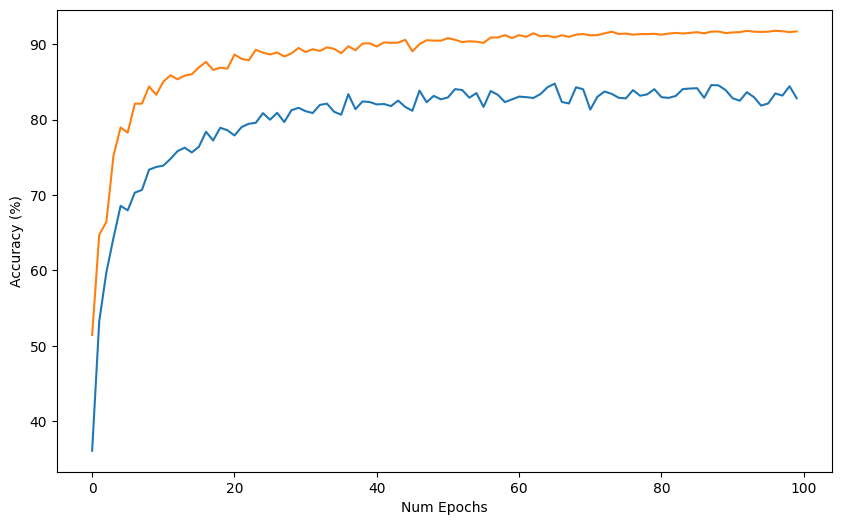

In [27]:
import matplotlib.pyplot as plt

if not os.path.exists("./plot"):
    os.makedirs("./plot")
    print("Creating a new directory")

def plot_loss(train_loss, val_loss, loss_fig):
    plt.figure(figsize = (10, 6))
    plt.plot(range(num_epochs), train_loss)
    plt.plot(range(num_epochs), val_loss)

    plt.xlabel("Num Epochs")
    plt.ylabel("Loss Value")
    
    plt.savefig(loss_fig)
    plt.show()

def plot_accuracy(train_acc, val_acc, acc_fig):
    plt.figure(figsize = (10, 6))
    plt.plot(range(num_epochs), train_acc)
    plt.plot(range(num_epochs), val_acc)

    plt.xlabel("Num Epochs")
    plt.ylabel("Accuracy (%)")
    
    plt.savefig(acc_fig)
    plt.show()

loss_path = "./plot/loss_mobilenetv3small_cifar10.png"
acc_path = "./plot/acc_mobilenetv3small_cifar10.png"

plot_loss(train_loss, val_loss, loss_path)
plot_accuracy(train_acc, val_acc, acc_path)